In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=0.8
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'lrecon' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
# check if data is imputed or not
IMPUTED_DATA = 'No' # 'Yes' if imputed
SOURCE_DATA_FILES = 'data/base_data/' #'data/imputed_data/recategorized/imputation_cart/'
FILE_SUFFIX = '' #'_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
if IMPUTED_DATA == 'Yes':
    valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
    valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

# Data preprocessing
Preprocessing steps (after imputation in R)

In [4]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X_train = data_X
X_test = test_X
y_train = data_y
y_test = test_y

In [5]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [6]:
X_train_base = X_train
y_train_base = y_train

# Oversampling to balance the dataset regarding target variable

In [7]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [8]:
y_train.value_counts()

lrecon_factor
0.0              358
1.0              358
2.0              358
3.0              358
4.0              358
5.0              358
6.0              358
7.0              358
8.0              358
9.0              358
10.0             358
dtype: int64

# Principal Component Analysis: reduce dimensionality

In [9]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [10]:
finalDf[target_factor].factorize()[0]

array([0, 1, 1, ..., 4, 4, 4])

In [11]:
finalDf.head()

,PC1,PC2,lrecon_factor
0,-6.353128,1.474979,5.0
1,0.844546,7.536058,8.0
2,-3.918881,3.759256,8.0
3,1.412884,0.471258,7.0
4,10.372820,1.794540,8.0


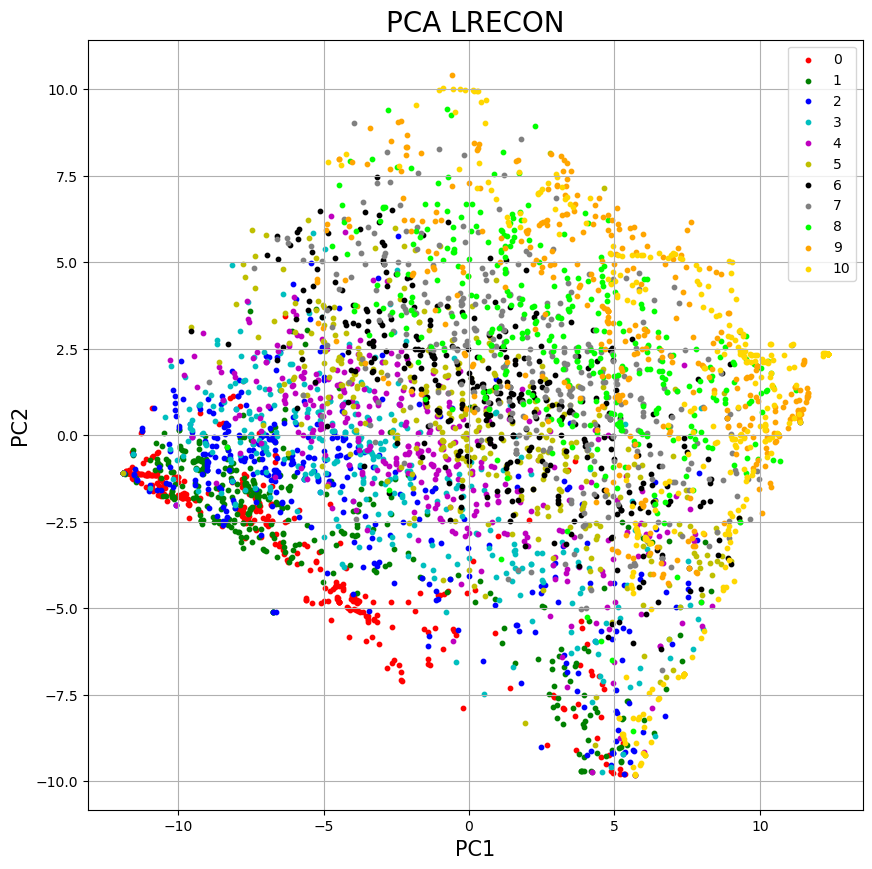

In [12]:
# visualize the results of the PCA
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA LRECON', fontsize = 20)

targets = range(0,12)
colors = ['r', 'g', 'b', 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor] == target #indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [13]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.63266418, 0.21042892])

# Clustering
Check if some patterns can be observed using unsupervised learning

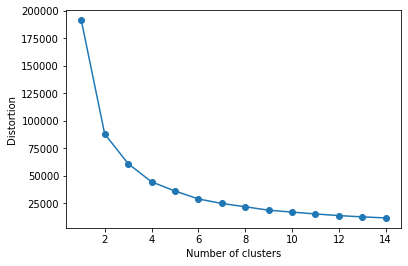

In [14]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [15]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [16]:
y_km

array([0, 3, 3, ..., 2, 1, 1], dtype=int32)

In [17]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [18]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

,PC1,PC2,lrecon_factor,cluster
0,-6.353128,1.474979,5.0,0
1,0.844546,7.536058,8.0,3
2,-3.918881,3.759256,8.0,3
3,1.412884,0.471258,7.0,3
4,10.372820,1.794540,8.0,1
5,-6.603363,2.619414,4.0,0
6,9.057015,-0.100873,10.0,1
7,-1.358656,0.302921,7.0,3
8,1.477939,-3.694687,3.0,2
9,-1.042969,0.706465,6.0,3


In [19]:
cluster_data.pivot_table(aggfunc='count', columns = [target_factor, 'cluster']).T

PC1  PC2
lrecon_factor cluster          
0.0           0        294  294
              2         64   64
1.0           0        276  276
              2         77   77
              3          5    5
2.0           0        248  248
              1          2    2
              2         87   87
              3         21   21
3.0           0        213  213
              1          3    3
              2         86   86
              3         56   56
4.0           0        125  125
              1          8    8
              2         91   91
              3        134  134
5.0           0         61   61
              1         20   20
              2        102  102
              3        175  175
6.0           0         21   21
              1         54   54
              2         63   63
              3        220  220
7.0           0         12   12
              1        106  106
              2         42   42
              3        198  198
8.0           0          2    2
              1        151  151
              2         18   18
              3        187  187
9.0           0          3    3
              1        195  195
              2         31   31
              3        129  129
10.0          1        242  242
              2         69   69
              3         47   47

# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [20]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']
cv_nr = 5

In [21]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.39213198 0.38959391 0.40228426 0.37484117 0.44091487]
0.40 accuracy with a standard deviation of 0.02


In [22]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
#print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

0.5748470621710059
{'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.341


## Random Forest Classification

In [23]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

0.5541257646891451
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__n_estimators': 95}
Test accuracy: 0.392


In [24]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Logistic Regression Classification

In [25]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

0.39467207284108696
{'logisticregression__C': 10.0}
Test accuracy: 0.319


## ADABoost Classification (Ensemble Method)

In [26]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(X_test, y_test))

0.30096742068573057
{'adaboostclassifier__n_estimators': 10}
Test accuracy: 0.253


In [27]:
gsADAB.scoring

'balanced_accuracy'

# Test models with independent dataset

In [28]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [29]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

0.2534722222222222

In [30]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

array([[ 7,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  3,  0,  0,  2,  0,  0,  0,  0,  0,  1],
       [15,  8,  0,  3,  3,  0,  0,  0,  1,  0,  0],
       [ 2,  5,  1,  7, 16,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  1,  1, 22,  0,  1,  0,  2,  0,  1],
       [ 0,  1,  2,  2, 18,  0,  1,  1, 29,  3,  4],
       [ 1,  0,  1,  1,  5,  0,  0,  0, 21,  0,  1],
       [ 0,  0,  0,  0,  5,  0,  0,  0, 19,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0,  8],
       [ 0,  0,  0,  1,  0,  0,  1,  0,  7,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  4]])

In [31]:
sklearn.metrics.mean_squared_error(test_y, gsADAB.predict(test_X))

4.361111111111111

In [32]:
sklearn.metrics.f1_score(test_y, gsADAB.predict(test_X), average='weighted')

0.15635138824239753

In [33]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

0.3194444444444444

In [34]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

array([[ 8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  3,  2,  3,  0,  1,  0,  0,  0,  0,  0],
       [ 1, 11,  9,  7,  1,  1,  0,  0,  0,  0,  0],
       [ 2,  2,  6, 11,  9,  1,  0,  0,  0,  0,  1],
       [ 0,  1,  2,  8, 14,  4,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  5, 11, 23, 13,  3,  0,  0,  4],
       [ 0,  0,  0,  3,  2,  5,  7,  5,  5,  1,  2],
       [ 0,  0,  0,  0,  3,  3,  5,  5,  6,  1,  2],
       [ 0,  0,  0,  0,  0,  1,  4,  2,  6, 12, 13],
       [ 0,  0,  0,  1,  0,  0,  0,  1,  3,  3,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3]])

In [35]:
sklearn.metrics.mean_squared_error(test_y, gsLR.predict(test_X))

2.4166666666666665

In [36]:
sklearn.metrics.f1_score(test_y, gsLR.predict(test_X), average='weighted')

0.3241299263034222

In [37]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

0.3923611111111111

In [38]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

array([[ 6,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  7,  3,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  5, 14, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  6, 13,  8,  1,  1,  1,  0,  0,  0],
       [ 1,  0,  1,  6, 19,  2,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  4, 19, 20, 10,  3,  3,  0,  0],
       [ 0,  0,  1,  2,  1,  8,  7,  6,  5,  0,  0],
       [ 0,  0,  0,  0,  4,  7,  2,  4,  7,  1,  0],
       [ 0,  0,  0,  0,  0,  2,  4,  6, 18,  6,  2],
       [ 0,  0,  0,  1,  0,  1,  0,  0,  5,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3]])

In [39]:
sklearn.metrics.mean_squared_error(test_y, gsRFC.predict(test_X))

1.7673611111111112

In [40]:
sklearn.metrics.f1_score(test_y, gsRFC.predict(test_X), average='weighted')

0.3855359803078141

In [41]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

0.3159722222222222

In [42]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

array([[ 7,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  5,  3,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  6, 12, 10,  0,  0,  0,  1,  0,  0,  0],
       [ 2,  3,  5, 11,  7,  1,  2,  1,  0,  0,  0],
       [ 0,  0,  3,  4, 15,  4,  3,  0,  0,  0,  0],
       [ 0,  0,  2, 10, 13, 15, 10,  2,  6,  3,  0],
       [ 0,  0,  1,  2,  2,  6,  7,  8,  3,  1,  0],
       [ 0,  0,  0,  0,  2,  5,  6,  3,  5,  4,  0],
       [ 0,  1,  0,  1,  2,  3,  2,  9, 12,  5,  3],
       [ 0,  0,  0,  2,  0,  0,  1,  0,  4,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2]])

In [43]:
sklearn.metrics.mean_squared_error(test_y, gsSVC.predict(test_X))

2.6979166666666665

In [44]:
sklearn.metrics.f1_score(test_y, gsSVC.predict(test_X), average='weighted')

0.31429151192314564

In [45]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [46]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [47]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [48]:
### Write several scores to the output ###

RMSE = True
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

{'standardscaler': StandardScaler(), 'adaboostclassifier': AdaBoostClassifier(random_state=1)}
Accuracy Score:  0.2534722222222222
Balanced Accuracy Score:  0.31403130671506346
Cohen-Kappa-Score:  0.17530167017394327
F1-Score:  0.15635138824239753
RMSE:  4.361111111111111
__________________________________

{'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(random_state=1)}
Accuracy Score:  0.3194444444444444
Balanced Accuracy Score:  0.3574805337448148
Cohen-Kappa-Score:  0.24419569932785268
F1-Score:  0.3241299263034222
RMSE:  2.4166666666666665
__________________________________

{'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(criterion='entropy', random_state=1)}
Accuracy Score:  0.3923611111111111
Balanced Accuracy Score:  0.4115583766768275
Cohen-Kappa-Score:  0.31615581878129195
F1-Score:  0.3855359803078141
RMSE:  1.7673611111111112
__________________________________

{'standardscaler': StandardScaler(), 'svc': SV

/home/gernot/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gernot/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gernot/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.3103735  0.11528149 0.26832438 0.10577233 0.1049088  0.0953395 ]


In [50]:
from joblib import dump, load
dump(gsRFC, 'models/gsRFC_lrecon_fulltarget_NoImputation.joblib') 
#clf = load('filename.joblib')


['models/gsRFC_lrecon_fulltarget_NoImputation.joblib']